In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import os
import pickle

import random

from mingpt.model import GPT
from model import setup_configs
from config import Detection
from utils import pickle_model


import matplotlib.pyplot as plt

Creating data points ...


In [2]:
class MetaNetwork(nn.Module):
    def __init__(self, num_queries, num_classes=1):
        super().__init__()
        input_size = 28 * 42 * num_queries

        print(f"query size (input): {input_size}")

        self.queries = nn.Parameter(torch.rand(num_queries, 28, 128))

        self.affines = nn.Linear(input_size, 2048)
        self.norm1 = nn.LayerNorm(2048)
        self.relu1 = nn.ReLU(True)

        self.dropout = nn.Dropout(0.5)

        self.lin2 = nn.Linear(2048, 512)
        self.norm2 = nn.LayerNorm(512)
        self.relu2 = nn.ReLU(True)

        self.dropout2 = nn.Dropout(0.5)

        self.lin3 = nn.Linear(512, 128)
        self.norm3 = nn.LayerNorm(128)
        self.relu3 = nn.ReLU(True)

        self.final_output = nn.Linear(128, num_classes)
    
    def forward(self, net):
        """
        :param net: an input network of one of the model_types specified at init
        :param data_source: the name of the data source
        :returns: a score for whether the network is a Trojan or not
        """
        query = self.queries
        out, _ = net(embeded=query)

        out = out.view(1, -1)

        out = self.affines(out)
        out = self.norm1(out)
        out = self.relu1(out)

        out = self.dropout(out)

        out = self.lin2(out)
        out = self.norm2(out)
        out = self.relu2(out)

        out = self.dropout2(out)

        out = self.lin3(out)
        out = self.norm3(out)
        out = self.relu3(out)

        return self.final_output(out)


In [3]:
def load_models(path: str, train_partition: float = 0.7) -> tuple[tuple[nn.Module, int], tuple[nn.Module, int]]: 
    train = []
    test = []

    test_clean_count = 0
    train_clean_count = 0

    failed = []
    with os.scandir(path) as files:
        for file in files: 
            try:
                with open(file.path, 'rb') as f:
                    checkpoint = pickle.load(f)
                    model_config, _ = setup_configs()
                    model = GPT(model_config)
                    model.load_state_dict(checkpoint)
                item = (
                    model,
                    0 if file.name.startswith("clean") else 1
                )
                if np.random.rand() < train_partition: 
                    train.append(item)
                    train_clean_count += file.name.startswith("clean")
                else: 
                    test.append(item)
                    test_clean_count += file.name.startswith("clean")
            except Exception:
                # print(f"corrupted pickle: {file.name}")
                failed.append(file.name)

    # test = np.random.permutation(test)
    # train = np.random.permutation(train)

    random.shuffle(train)
    random.shuffle(test)
    total = len(train) + len(test)
    total_clean = test_clean_count + train_clean_count


    print(f"Global partition: \n\t Total: {total} \n\tClean: {100*total_clean/total:.2f} \n\tTrojan: {100*(1 - total_clean/total):.2f}")
    print(f"Train partition: \n\tClean: {100 * train_clean_count / len(train):.2f}% \n\tTrojan: {100 * (1 - train_clean_count / len(train)) :.2f}%")
    print(f"Test partition: \n\tClean: {100 * test_clean_count / len(test):.2f}% \n\tTrojan: {100 * (1 - test_clean_count / len(test)) :.2f}%")


    if failed:
        with open("corrupted.sh", "w") as f:
            f.write("rm -f" + " ".join(failed))

    return train, test


In [4]:
def test_MNTD(model: nn.Module, data_models: tuple[nn.Module, int]) -> None:
    model.eval()
    loss_ema = np.inf
    loss = 0
    total = 0
    correct = 0

    for i, (net, label) in enumerate(data_models):
        net.eval()
        out = model(net)
        loss = F.binary_cross_entropy_with_logits(out, torch.FloatTensor([label]).unsqueeze(0))
        # loss.backward(inputs=list(model.parameters()))
        # model.queries.data = model.queries.data.clamp(0, 1)
        loss_ema = loss.item() if loss_ema == np.inf else 0.95 * loss_ema + 0.05 * loss.item()
        loss += loss_ema
        loss += sum(Detection.LAMBDA_L1 * torch.norm(parameter, 1) for parameter in model.parameters()) ## L1 regularization
        
        # print(out.item(), label)
        correct += (out.item() - 1/2) * (label - 1/2) > 0
        total += 1

    print(f"loss {loss}")
    print(f"acuracy: {correct/total:.5f}")
    return loss, correct/total

In [5]:
def train_MNTD(model: nn.Module, data_models: tuple[nn.Module, int], validation_split: float = 0.3) -> None:
    print("training model\n\n")

    random.shuffle(data_models)
    partition_point = int(len(data_models)*validation_split)
    validation_data_models = data_models[:partition_point]
    train_data_models = data_models[partition_point:]

    print(f"Train partition: {len(train_data_models)}")
    print(f"Validation partition: {len(validation_data_models)}")

    model.train()
    num_epochs = Detection.NUM_EPOCHS
    lr = Detection.LEARNING_RATE
    weight_decay = Detection.WEIGHT_DECAY
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs * len(train_data_models))

    loss_ema = np.inf

    test_losses = []
    train_losses = []
    test_accuracies = []

    best_model = None
    best_model_loss = float('inf')
    best_model_accuracy = 0


    try:
        for epoch in range(num_epochs):
            epoch_loss = 0 

            model.train()
            for i, (net, label) in enumerate(train_data_models):
                net.eval()

                out = model(net)

                loss = F.binary_cross_entropy_with_logits(out, torch.FloatTensor([label]).unsqueeze(0))
                loss += sum(Detection.LAMBDA_L1 * torch.norm(parameter, 1) for parameter in model.parameters()) ## L1 regularization

                optimizer.zero_grad()
                loss.backward(inputs=list(model.parameters()))
                optimizer.step()
                scheduler.step()
                model.queries.data = model.queries.data.clamp(0, 1)
                loss_ema = loss.item() if loss_ema == np.inf else 0.95 * loss_ema + 0.05 * loss.item()
                epoch_loss += loss_ema

            print("\nValidation batch:")
            test_loss, test_acc = test_MNTD(model, validation_data_models)
            test_losses.append(test_loss.item())
            test_accuracies.append(test_acc)
            train_losses.append(epoch_loss)

            print(f"train batch: epoch {epoch} - loss {epoch_loss}")

            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
            ax1.plot(test_losses)
            ax1.set_title('Test losses')

            ax2.plot(train_losses)
            ax2.set_title('Train losses')

            ax3.plot(test_accuracies)
            ax3.set_title('Test Accuracy')

            plt.show()

            # saving best result from loss measure
            # if test_loss < best_model_loss:
            #     best_model_loss = test_loss
            #     best_model = model.state_dict()

            # saving best result from accuracy measure
            if test_acc > best_model_accuracy:
                best_model_accuracy = test_acc
                best_model = model.state_dict()

            pickle_model("backup", f"meta_{i}",  model)

    finally:
        return test_losses, test_accuracies, train_losses, best_model

In [5]:
train, test = load_models("/run/media/guilherme.vieira-manhaes/UBUNTU 22_1/psc/finals", .7)

Global partition: 
	 Total: 4640 
	Clean: 51.40 
	Trojan: 48.60
Train partition: 
	Clean: 51.35% 
	Trojan: 48.65%
Test partition: 
	Clean: 51.51% 
	Trojan: 48.49%


query size (input): 11760
training model


Train partition: 2984
Validation partition: 331

Validation batch:
loss 3.918487787246704
acuracy: 0.48640
train batch: epoch 0 - loss 15055.869447688576


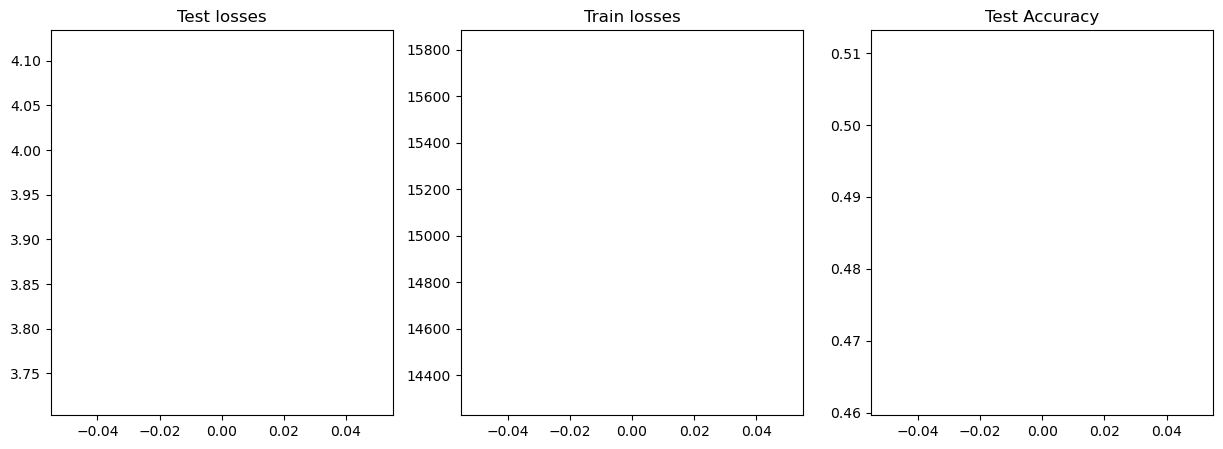


Validation batch:
loss 3.2786197662353516
acuracy: 0.53172
train batch: epoch 1 - loss 7103.435969857802


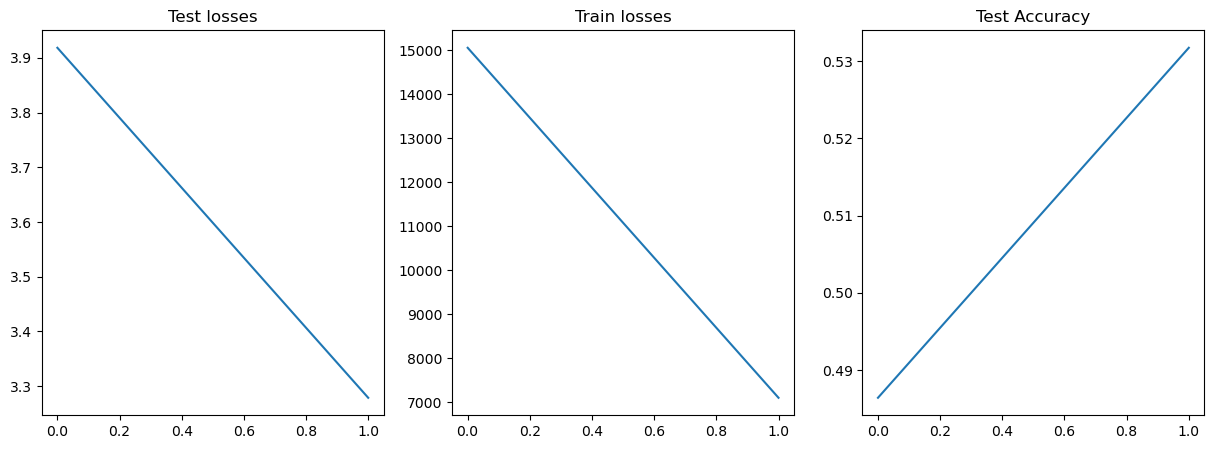


Validation batch:
loss 3.2981786727905273
acuracy: 0.58308
train batch: epoch 2 - loss 5997.852115729152


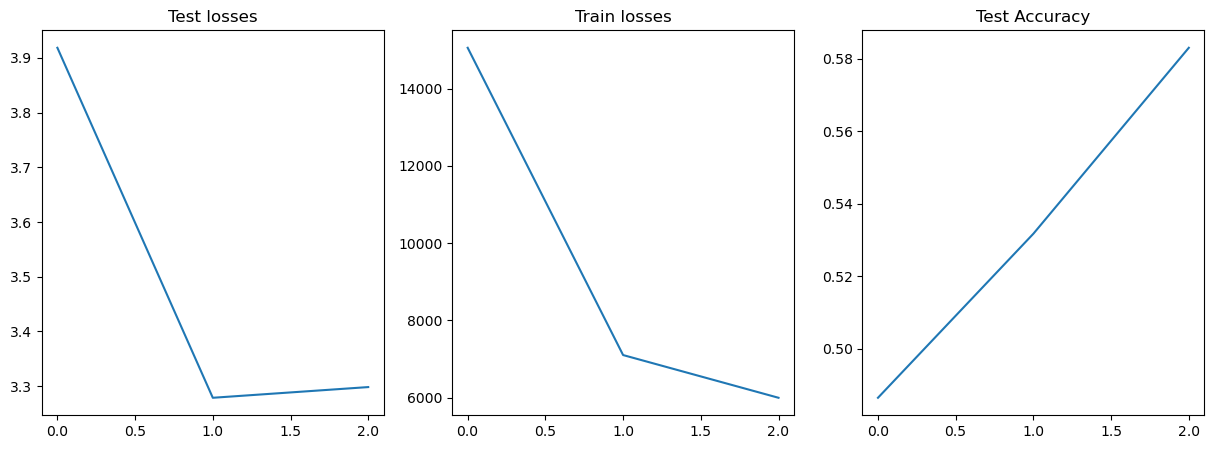


Validation batch:
loss 3.4125051498413086
acuracy: 0.61631
train batch: epoch 3 - loss 5508.534682614168


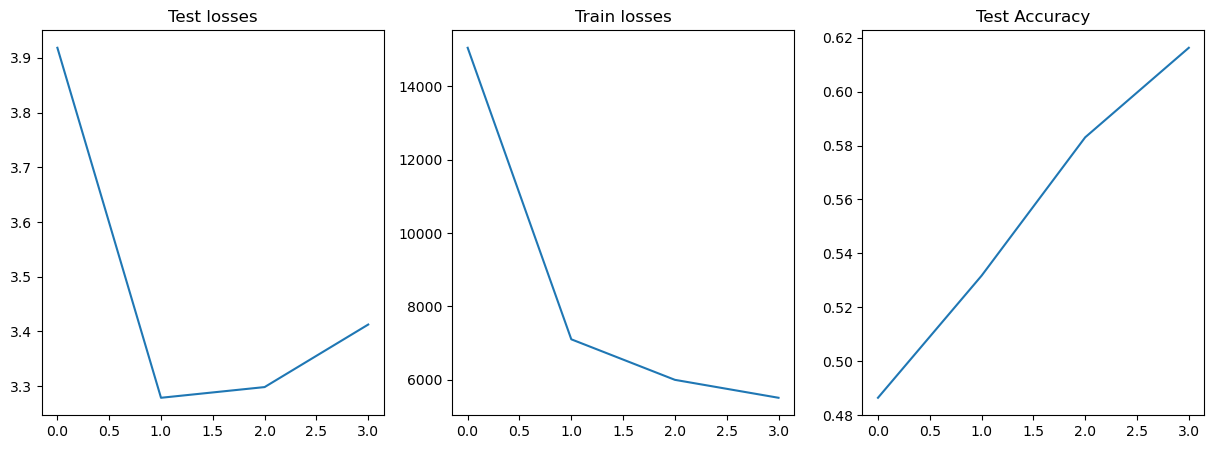


Validation batch:
loss 3.377979278564453
acuracy: 0.61631
train batch: epoch 4 - loss 5124.449670512689


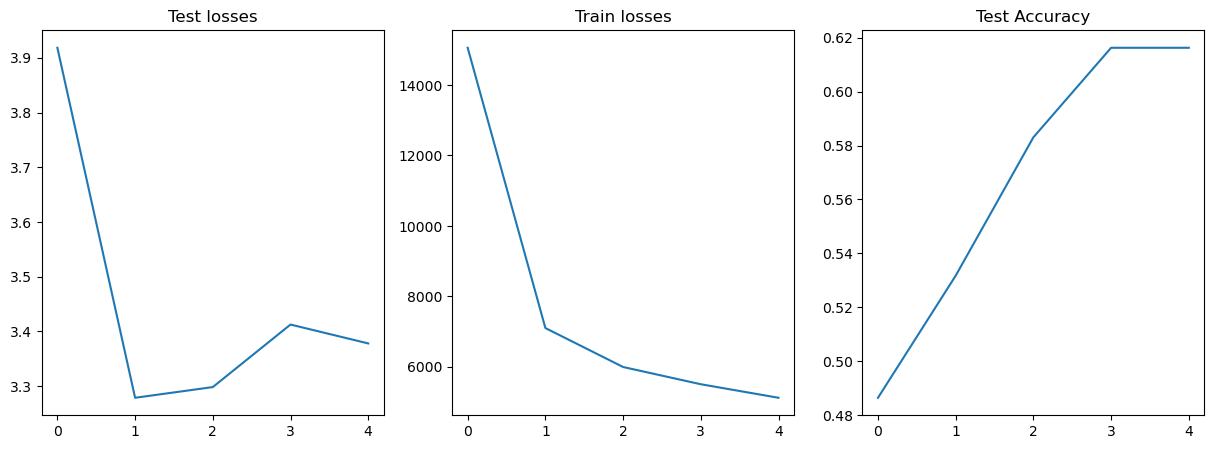


Validation batch:
loss 3.5933945178985596
acuracy: 0.64955
train batch: epoch 5 - loss 4892.256944805408


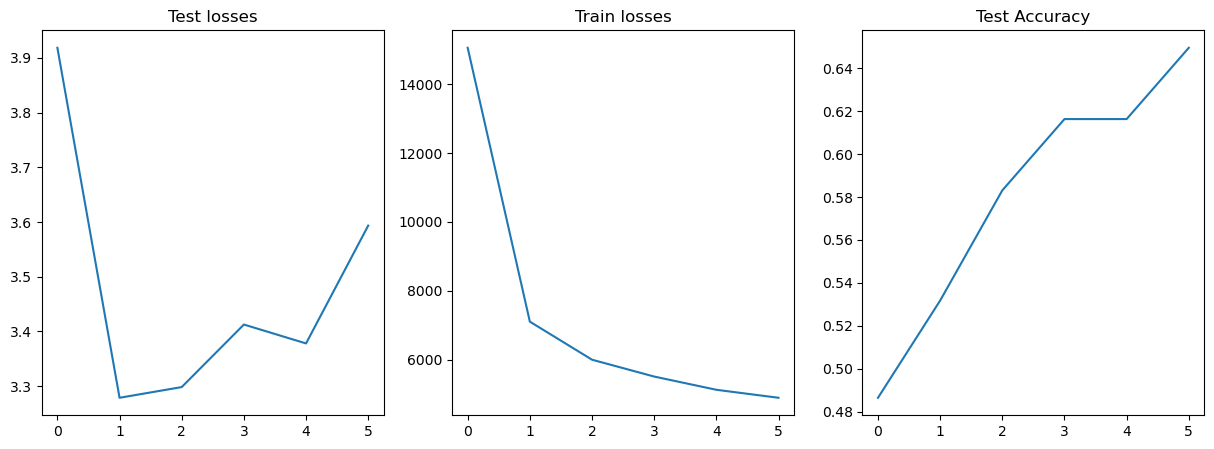


Validation batch:
loss 3.291653633117676
acuracy: 0.67372
train batch: epoch 6 - loss 4741.118669557722


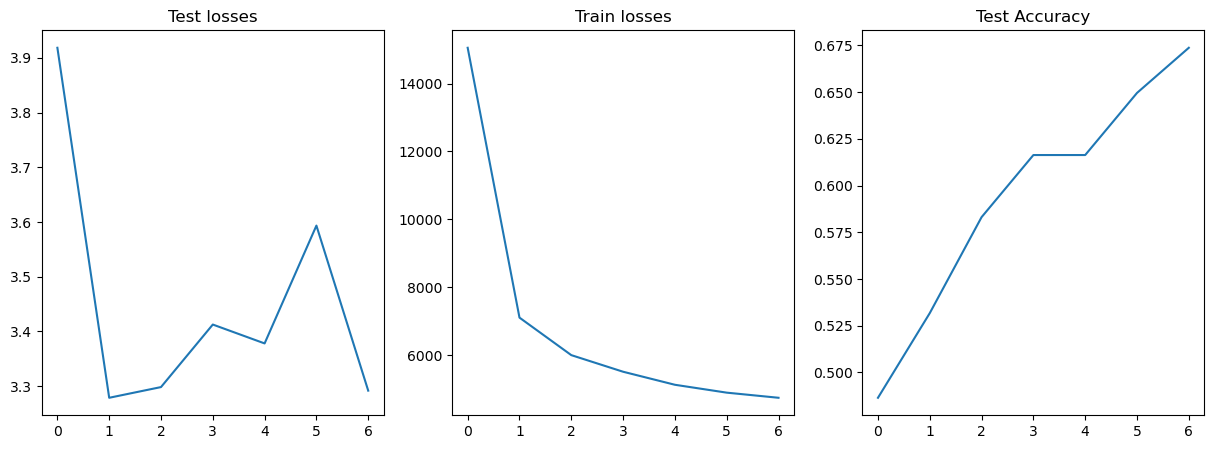


Validation batch:
loss 3.270454168319702
acuracy: 0.67372
train batch: epoch 7 - loss 4541.375061609256


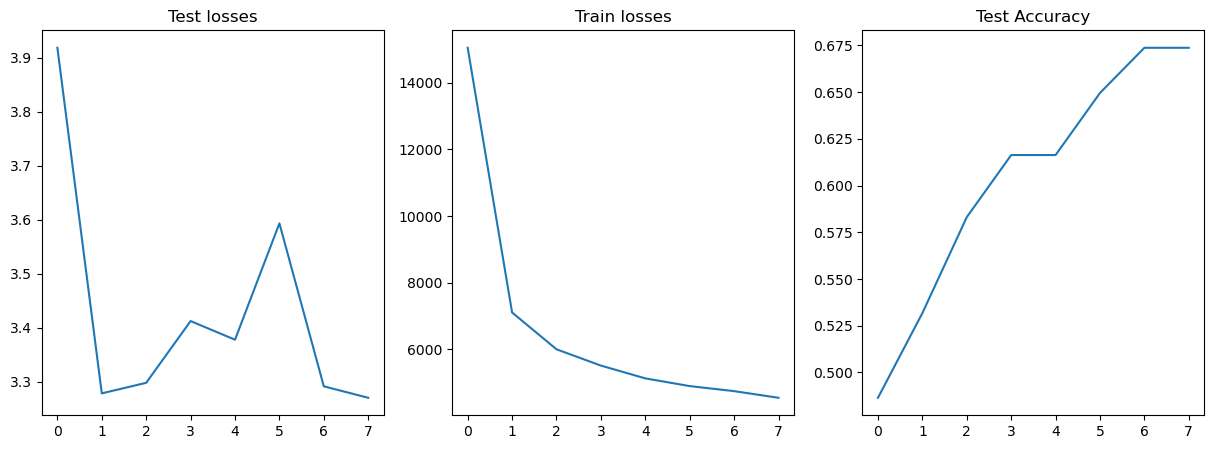


Validation batch:
loss 3.2234716415405273
acuracy: 0.67976
train batch: epoch 8 - loss 4414.664413163009


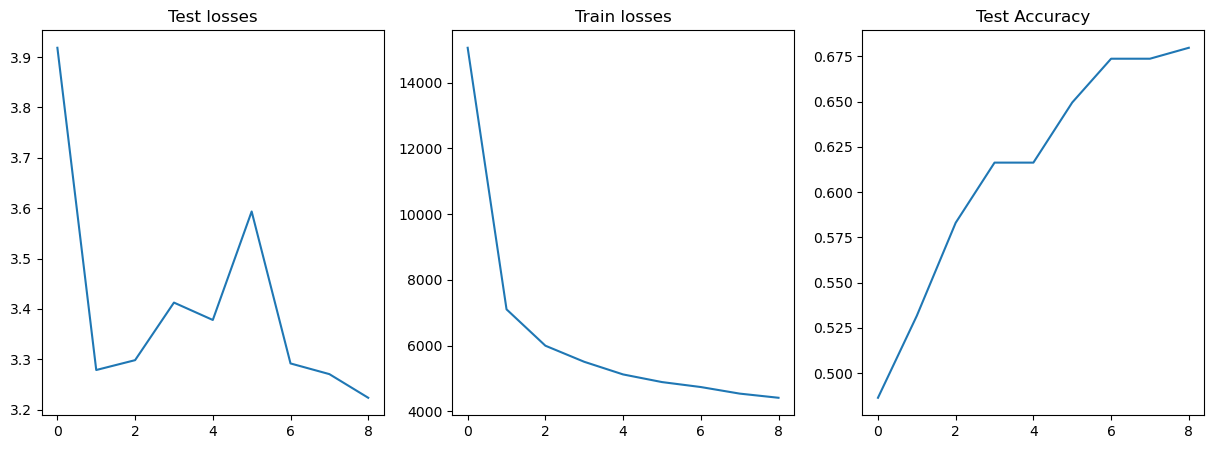


Validation batch:
loss 2.9476728439331055
acuracy: 0.69184
train batch: epoch 9 - loss 4314.636389304711


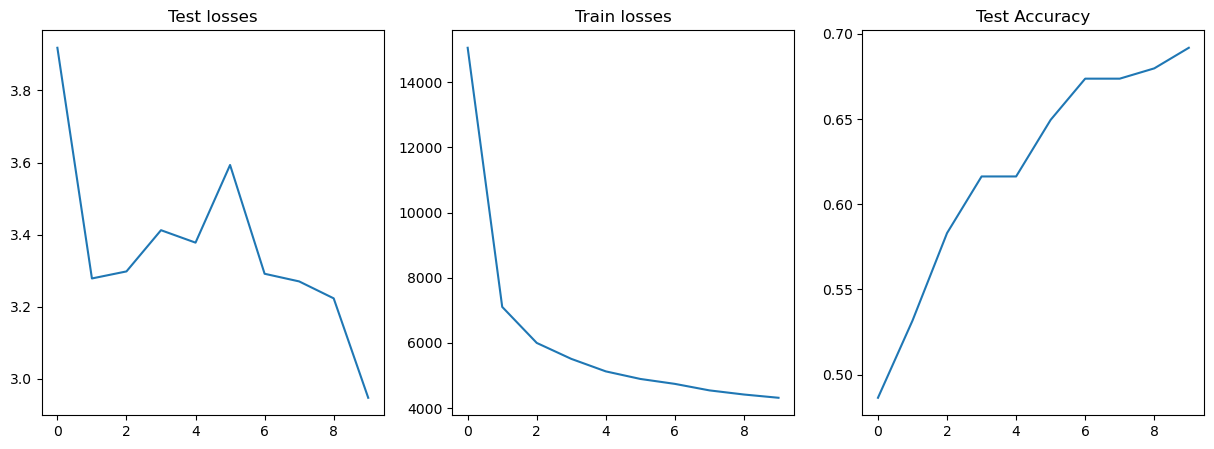


Validation batch:
loss 3.348706007003784
acuracy: 0.67372
train batch: epoch 10 - loss 4189.86745858107


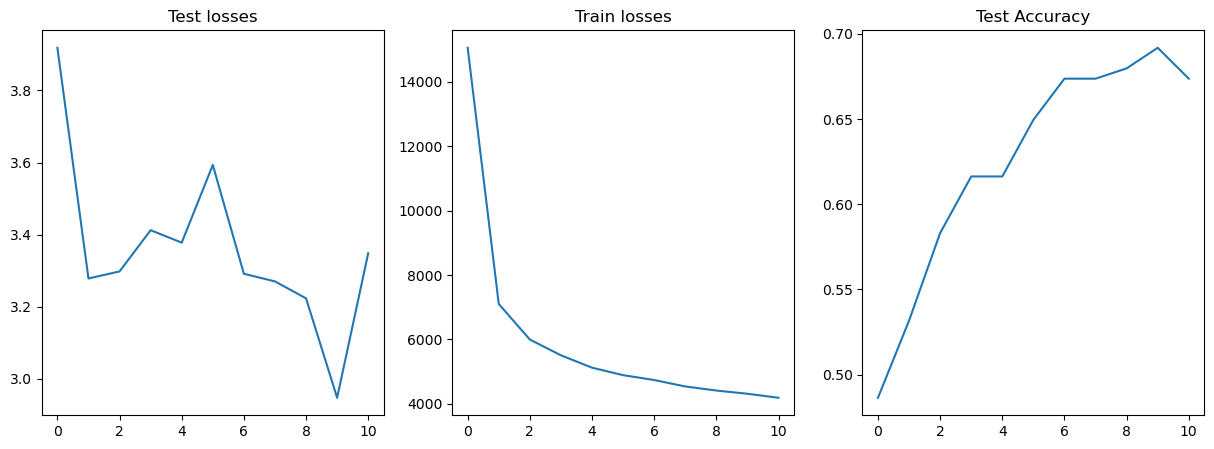


Validation batch:
loss 2.9376914501190186
acuracy: 0.71299
train batch: epoch 11 - loss 4105.256028329093


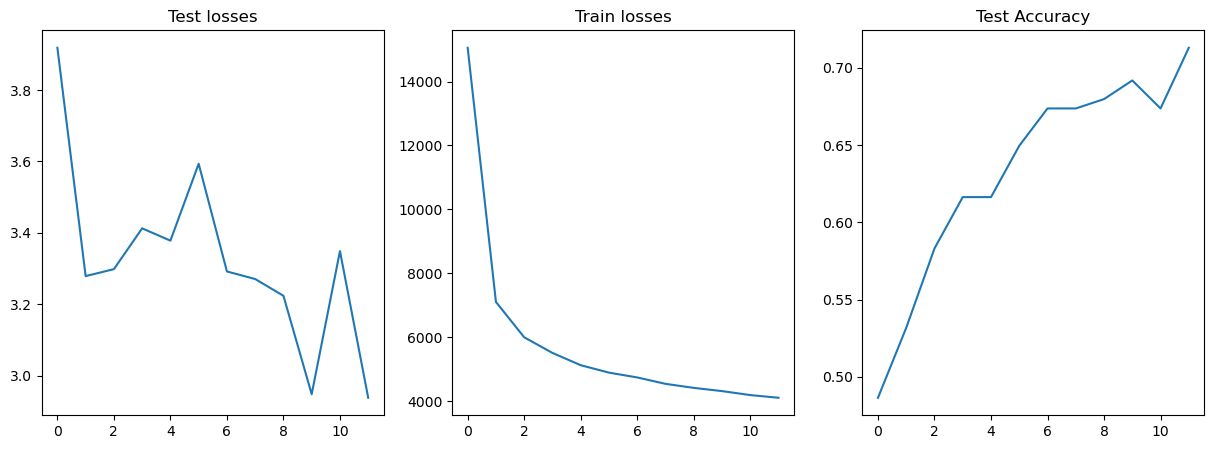


Validation batch:
loss 3.612602949142456
acuracy: 0.73112
train batch: epoch 12 - loss 3958.9554102354305


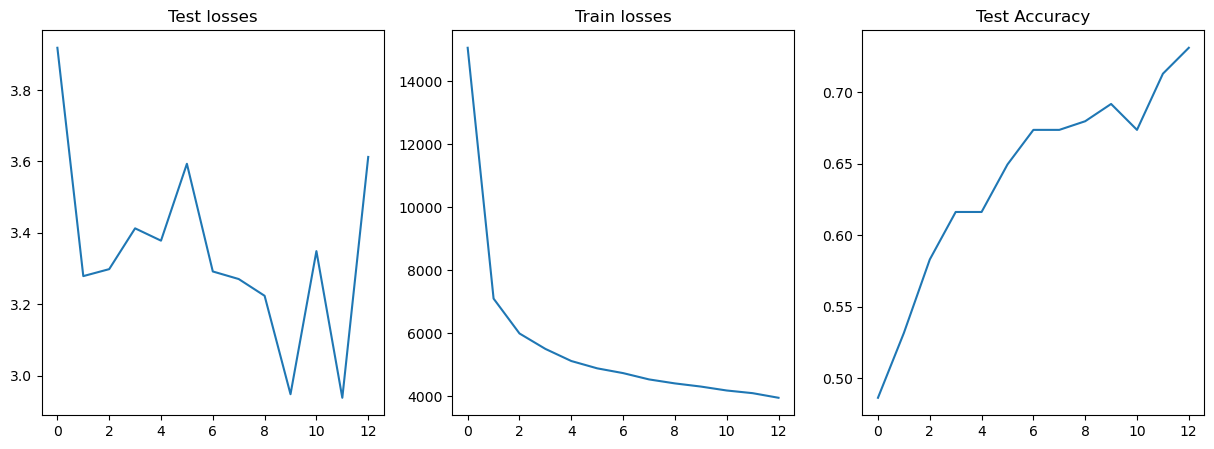


Validation batch:
loss 3.4080820083618164
acuracy: 0.73716
train batch: epoch 13 - loss 3912.6193323658713


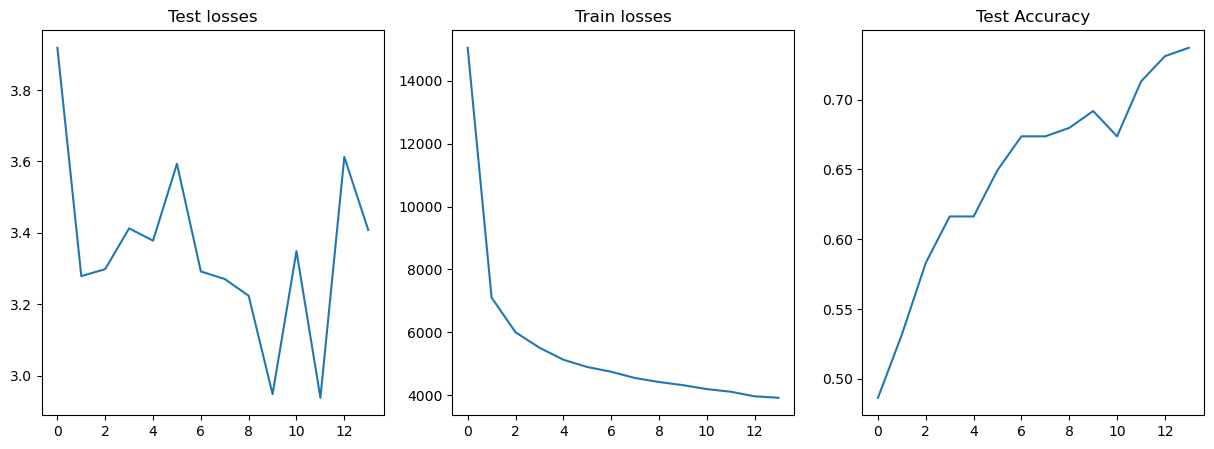


Validation batch:
loss 3.500683069229126
acuracy: 0.71299
train batch: epoch 14 - loss 3821.868776828919


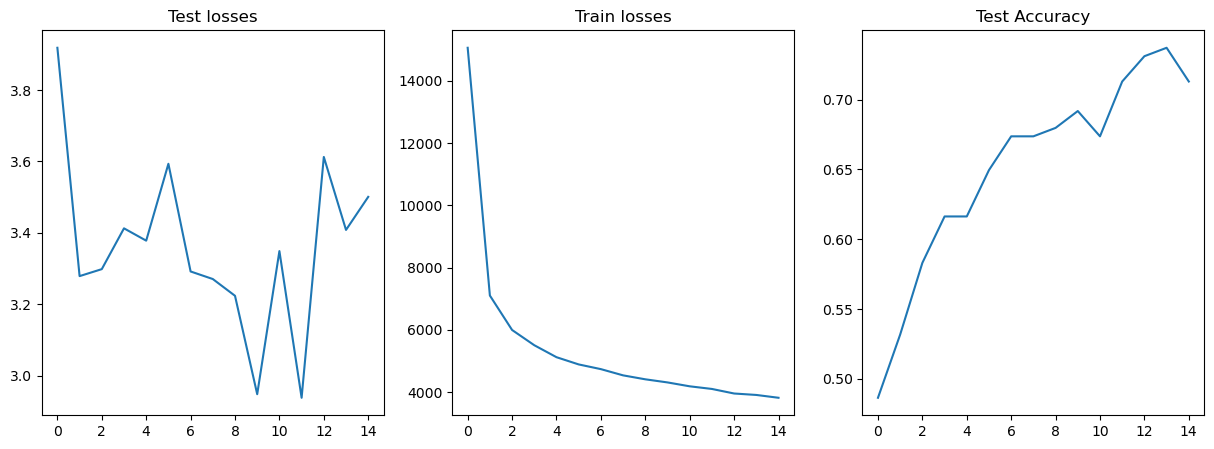


Validation batch:
loss 3.580085039138794
acuracy: 0.70695
train batch: epoch 15 - loss 3775.780009161303


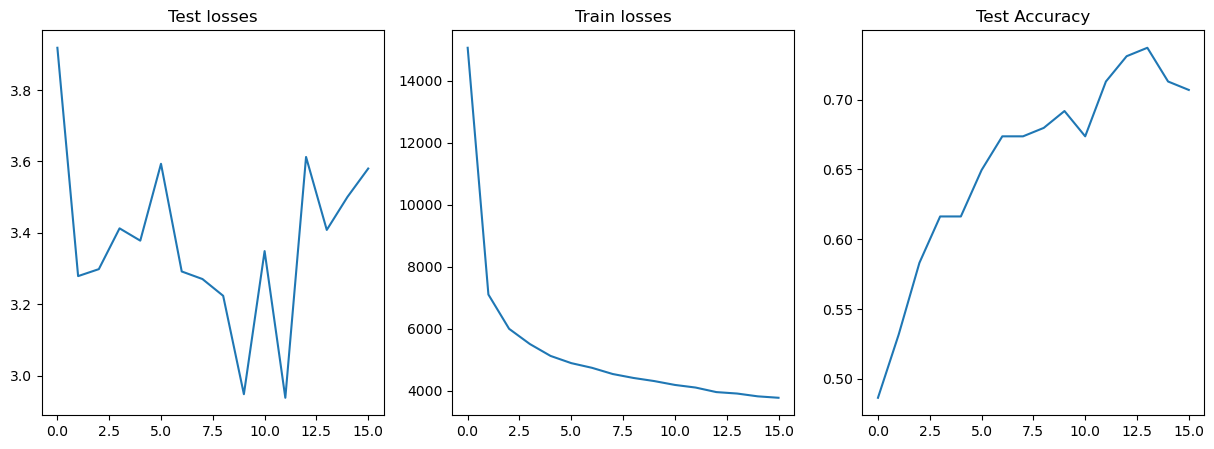


Validation batch:
loss 3.6195130348205566
acuracy: 0.70695
train batch: epoch 16 - loss 3664.220556619968


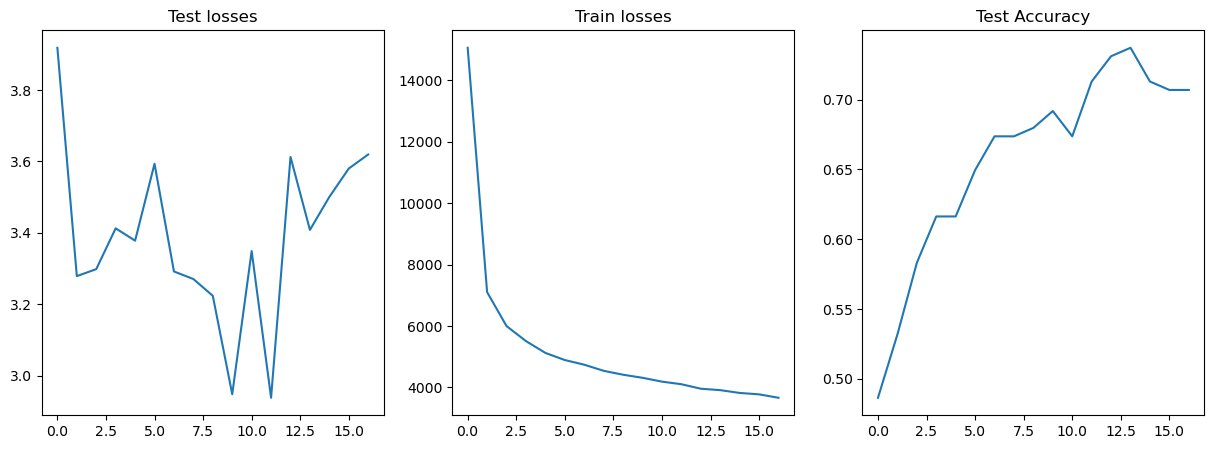


Validation batch:
loss 3.4754326343536377
acuracy: 0.69789
train batch: epoch 17 - loss 3591.570886089842


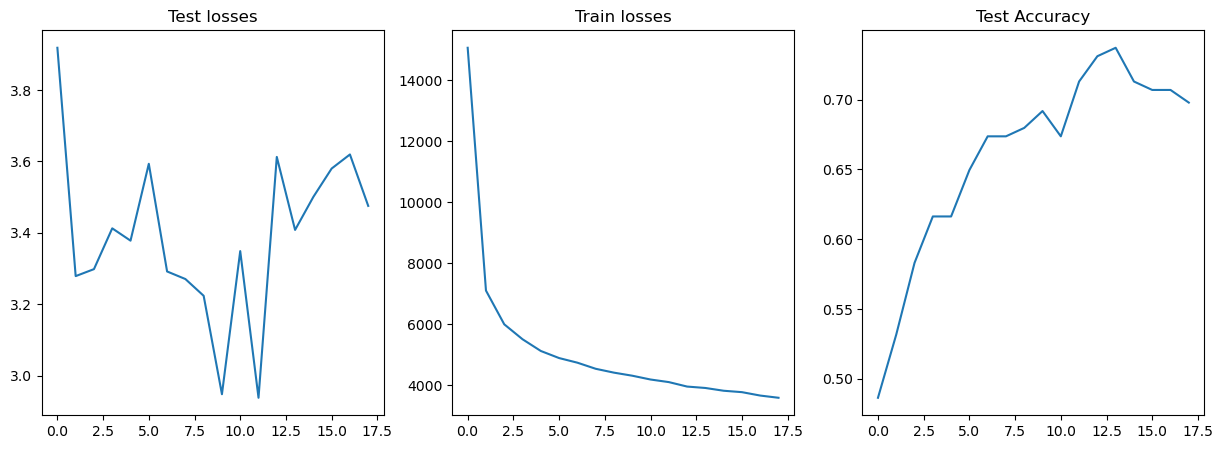


Validation batch:
loss 3.5851259231567383
acuracy: 0.71299
train batch: epoch 18 - loss 3552.0590135637985


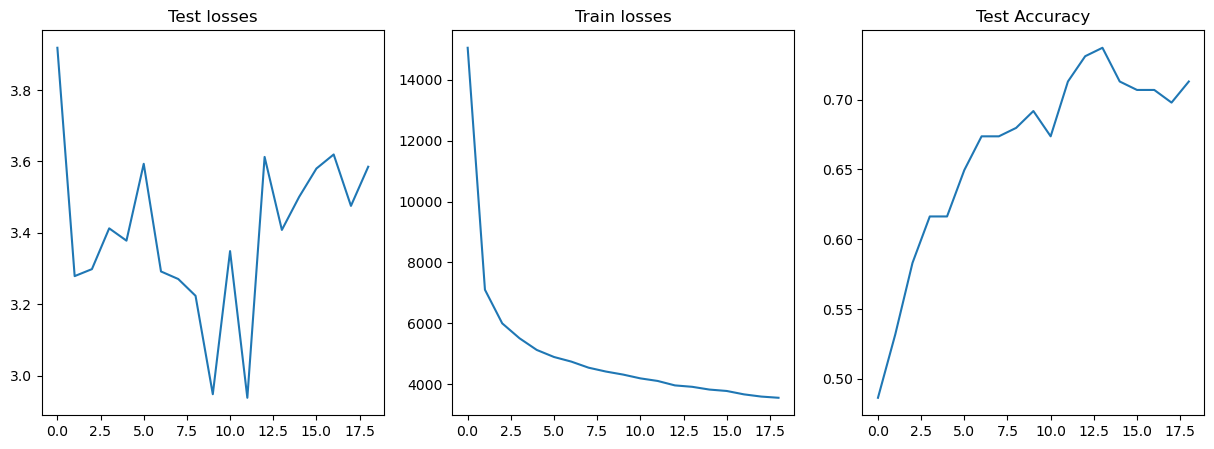


Validation batch:
loss 3.6264734268188477
acuracy: 0.71601
train batch: epoch 19 - loss 3434.1137075678776


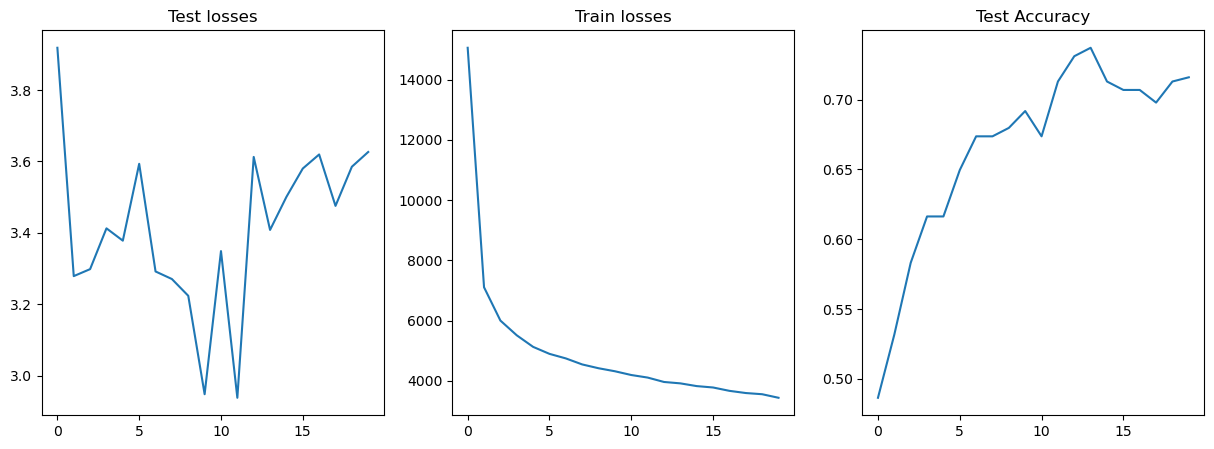

In [7]:
meta_network = MetaNetwork(Detection.NUM_QUERIES)
test_losses, test_acc, train_losses, best_model = train_MNTD(meta_network, train, validation_split=0.1)

In [ ]:
test_MNTD(meta_network, test)

query size (input): 11760
loss 1.6719774007797241
acuracy: 0.73403
query size (input): 11760
loss 1.6707303524017334
acuracy: 0.71694
query size (input): 11760
loss 2.483567714691162
acuracy: 0.60401
query size (input): 11760
loss 13.63547134399414
acuracy: 0.55795
query size (input): 11760
loss 13.74172306060791
acuracy: 0.50149


In [ ]:
net = MetaNetwork(Detection.NUM_QUERIES)
net.load_state_dict(best_model)
test_MNTD(net, test)

query size (input): 11760
loss 1.6857534646987915
acuracy: 0.73180
query size (input): 11760
loss 1.6708415746688843
acuracy: 0.71694
query size (input): 11760
loss 2.536830186843872
acuracy: 0.60698
query size (input): 11760


TypeError: Expected state_dict to be dict-like, got <class 'NoneType'>.

Testing with new unseen data


In [9]:
_, test_unseen = load_models("/users/eleves-b/2021/guilherme.vieira-manhaes/finals", 0.01)

Global partition: 
	 Total: 716 
	Clean: 48.32 
	Trojan: 51.68
Train partition: 
	Clean: 25.00% 
	Trojan: 75.00%
Test partition: 
	Clean: 48.46% 
	Trojan: 51.54%


In [11]:
with open("backup/meta_2983.pkl", "rb") as f:
    state = pickle.load(f)


net = MetaNetwork(Detection.NUM_QUERIES)
net.load_state_dict(state)
test_MNTD(net, test_unseen)

query size (input): 11760
loss 1.7763714790344238
acuracy: 0.72612


(tensor(1.7764, grad_fn=<AddBackward0>), 0.726123595505618)